### Importing required modules

In [12]:
### Importing basic libraries
import scipy.io
import os
import numpy as np
import torch
from scipy import signal
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import random
import pandas as pd
import scipy
import pickle
import sklearn
from sklearn.preprocessing import MinMaxScaler
import warnings
import math
import csv
from tqdm.notebook import tqdm

from scipy.signal import butter, lfilter, lfilter_zi
from pylab import plot, show, title, xlabel, ylabel, subplot

### Importing torch related libraries
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.nn as nn
import torch.functional as F
from torch.autograd import Variable   
import torch.optim as optim
from torch.optim import lr_scheduler
import datetime

### Importing Custom Libraries
from network import IncUNet

# Preprocessing #

### Navigate to the folder containing the model and data

In [13]:
data_path = "../Signals"
prepro = False
BATCH_SIZE = 16
#subj_all = [29, 40, 23, 27, 28, 30, 39, ]  # 41

subj_all = [29, 40, 23, 27, 28, 30, 33, 35, 36, 39, 45, 47, 49, 52, 57, 58, 62, 63, 64, 66, 69, 71, 73, 76, 82, 84, 88, 89, 90, 93, 95, 97, 98, 99, 100, 101, 103, 104, 105, 113, 117, 118, 119, 120, 121,  106, 107, 109, 110, 111,  112 ]  #41 

subj_all.pop(41)
subj_all.pop(45)



107

### Loading from the Mat file

In [14]:
count = 0 
patient_info = []

#for files in sorted(os.listdir(data_path)):
#    if "_prepro" in files:
#      count += 1
#      patient_info.append(scipy.io.loadmat(os.path.join(data_path,files)))
#patient_info.pop()

for ss in subj_all:
        patient_info.append(scipy.io.loadmat(f'../Signals/P0{ss:02d}_prepro.mat' if prepro else f'../Signals/P0{ss:02d}_raw.mat') if ss < 100 else scipy.io.loadmat(f'../Signals/P{ss:02d}_prepro.mat' if prepro else f'../Signals/P{ss:02d}_raw.mat'))

        count += 1

print(count)

49


In [15]:
count = 0 
patient_reference = []
'''for files in sorted(os.listdir(data_path)):
     if "_prepro" not in files and "_raw" not in files and files != "DatiAndrea.m":
      count += 1
      patient_reference.append(scipy.io.loadmat(os.path.join(data_path,files)))

patient_reference.pop()
print(count)'''

for ss in subj_all:
        patient_reference.append(scipy.io.loadmat(f'../Signals/P0{ss:02d}.mat') if ss<100 else scipy.io.loadmat(f'../Signals/P{ss:02d}.mat'))
        count += 1

print(len(patient_reference))

49


### To obtain the patient's ECG Record ###

In [16]:
#patient_eeg = np.asarray( [patient_info[i]['EEG_prepro' if prepro else 'EEG']['data'][0, 0][:max_len] for i in range(0,len(patient_info))] )
#print("Shape of the ECG record",patient_eeg.shape)
#patient_eeg = patient_eeg[:,:,0]


max_len = min(
    patient_info[i]['EEG_prepro' if prepro else 'EEG']['data'][0, 0].shape[-1] 
    for i in range(len(patient_info))
)

n_patients = len(patient_info)
n_channels = 128  # adjust if needed

patient_eeg = np.zeros((n_patients, n_channels, max_len), dtype=np.float32)

for i in range(n_patients):
    # Extract raw EEG
    raw = np.asarray(patient_info[i]['EEG_prepro' if prepro else 'EEG']['data'][0, 0])
    raw = np.squeeze(raw)  # remove singleton dims like (1, 90, T)
    
    eeg = raw[:, :max_len]   # (channels, time)
    patient_eeg[i, :, :] = eeg

print("Final EEG matrix shape:", patient_eeg.shape)

Final EEG matrix shape: (49, 128, 179207)



### Normalizing Patient ECG

In [17]:
# Previous global scaling removed; defer scaling to per-window stage.
patient_eeg_raw = patient_eeg  # (n_patients, n_channels, T)
print('Raw EEG retained for later window-wise scaling:', patient_eeg_raw.shape)

Raw EEG retained for later window-wise scaling: (49, 128, 179207)


### To obtain the Reference Value ###

In [18]:
#patient_ref = []
#for j in range(0,len(patient_reference)):
#    patient_ref.append(patient_reference[j]['R_peak'][0].ravel().astype(np.float16))

patient_ref = []  
ecg_list = []

for j in range(0,len(patient_reference)):
    peaks = patient_reference[j]['R_peak'][0].ravel()
    peaks = peaks.astype(np.float32, copy=False)

    eeg = patient_reference[j]['ECG_i'].flatten() 
    ecg_list.append(eeg[:max_len])

    # keep only indices in [0, max_len-1]
    valid_mask = (peaks >= 0) & (peaks < max_len)
    peaks = peaks[valid_mask]
    patient_ref.append(peaks)

print('patient_ref.shape (raw) =', len(patient_reference))

patient_ref.shape (raw) = 49


### Distance Transform- Obtaining ground truth

In [19]:
distance_transform = []

for i in range(len(patient_ref)):
    prev_qrs = patient_ref[i][0]
    next_qrs = patient_ref[i][1]
    dist_tran = np.zeros(patient_eeg.shape[2])
    beat_count = 1
    for j in range(len(dist_tran)):
        threshold = (prev_qrs + next_qrs) / 2
        if j < threshold:
            dist_tran[j] = abs(j - prev_qrs) / 250
        else:
            dist_tran[j] = abs(j - next_qrs) / 250
        if j == next_qrs and beat_count != len(patient_ref[i]) - 1:
            beat_count += 1
            prev_qrs = next_qrs
            next_qrs = patient_ref[i][beat_count]
    distance_transform.append(dist_tran)

# Per-window scaling will be applied later; keep raw values here.
distance_transform = np.asarray(distance_transform, dtype=np.float32)
print('distance_transform.shape (raw) =', distance_transform.shape)

distance_transform.shape (raw) = (49, 179207)


torch.Size([49, 1, 179207])


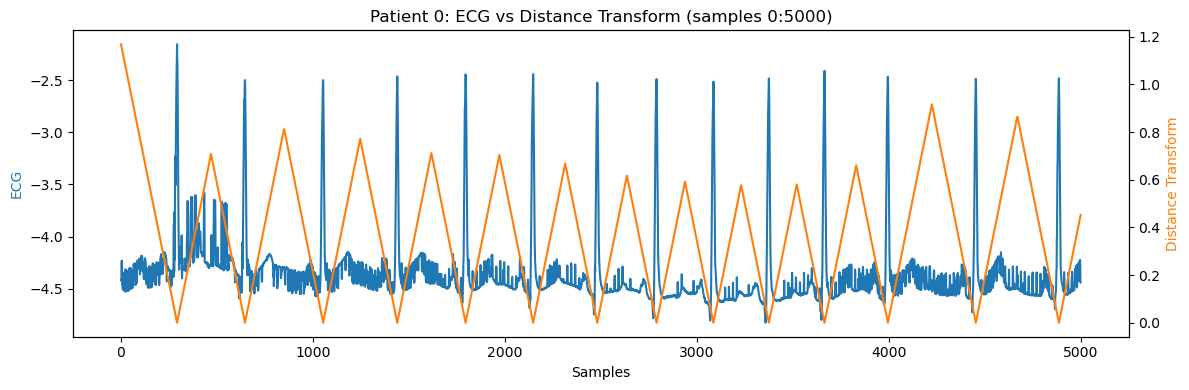

In [20]:
dist_transform = torch.Tensor(distance_transform)
dist_transform = dist_transform.view(dist_transform.shape[0],1,dist_transform.shape[1])
print(dist_transform.shape)


# Overlay plot of true ECG (ecg_list) vs distance transform, windowed
patient_idx = 0  # change to visualize a different subject
ecg_np = np.asarray(ecg_list[patient_idx])
dt_np = dist_transform[patient_idx, 0, :].numpy()

# ensure equal length and choose window
T = min(len(ecg_np), len(dt_np))
window_len = min(5000, T)  # pick a shorter window for readability
start = 0                   # change start index if desired
start = max(0, min(start, T - window_len))
end = start + window_len

ecg_win = ecg_np[start:end]
dt_win = dt_np[start:end]

plt.figure(figsize=(12,4))
ax1 = plt.gca()
ax1.plot(ecg_win, color='tab:blue', label='ECG')
ax1.set_xlabel('Samples')
ax1.set_ylabel('ECG', color='tab:blue')
ax2 = ax1.twinx()
ax2.plot(dt_win, color='tab:orange', label='Distance Transform')
ax2.set_ylabel('Distance Transform', color='tab:orange')
plt.title(f'Patient {patient_idx}: ECG vs Distance Transform (samples {start}:{end})')
plt.tight_layout()

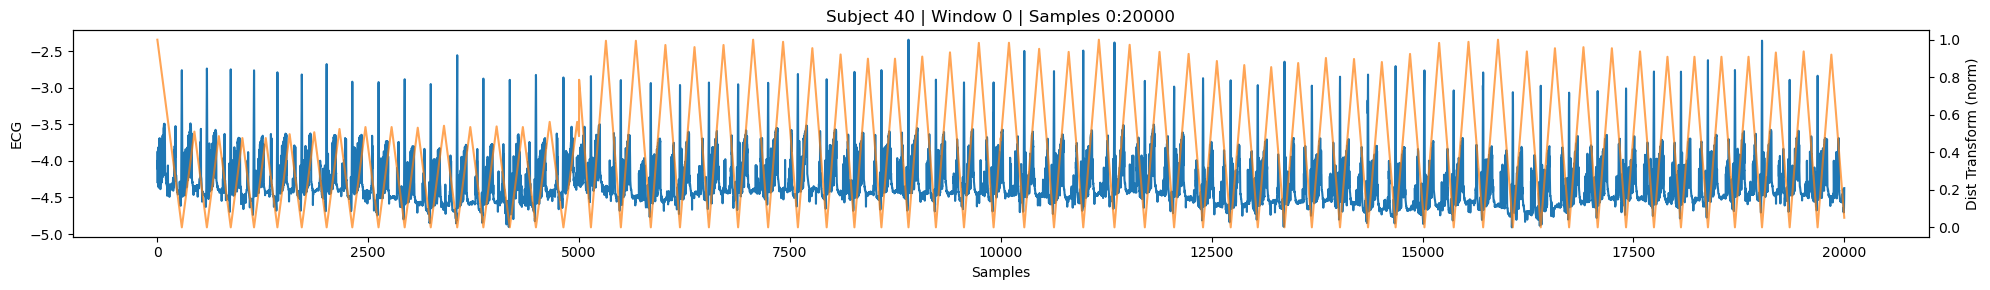

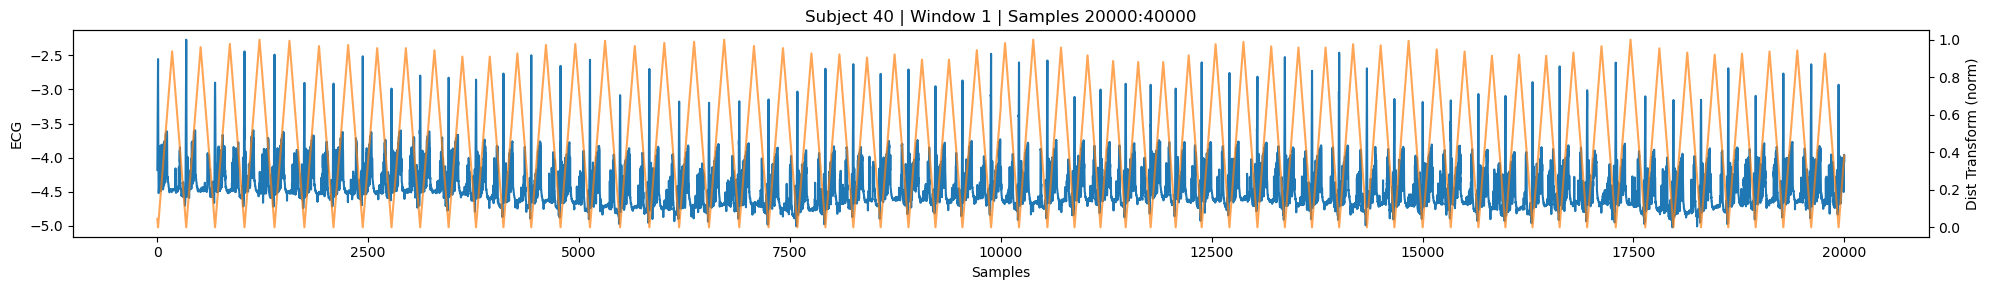

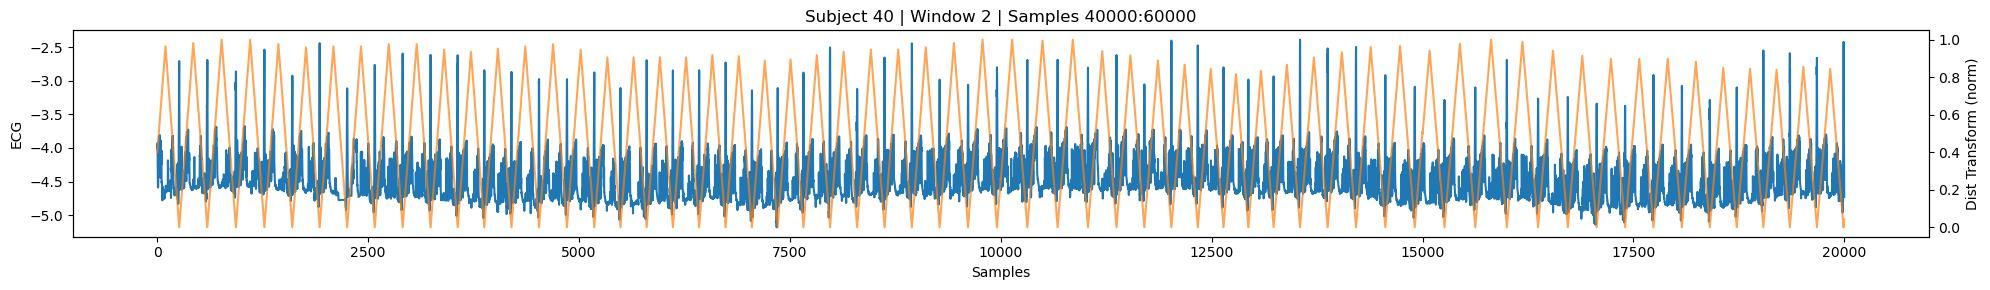

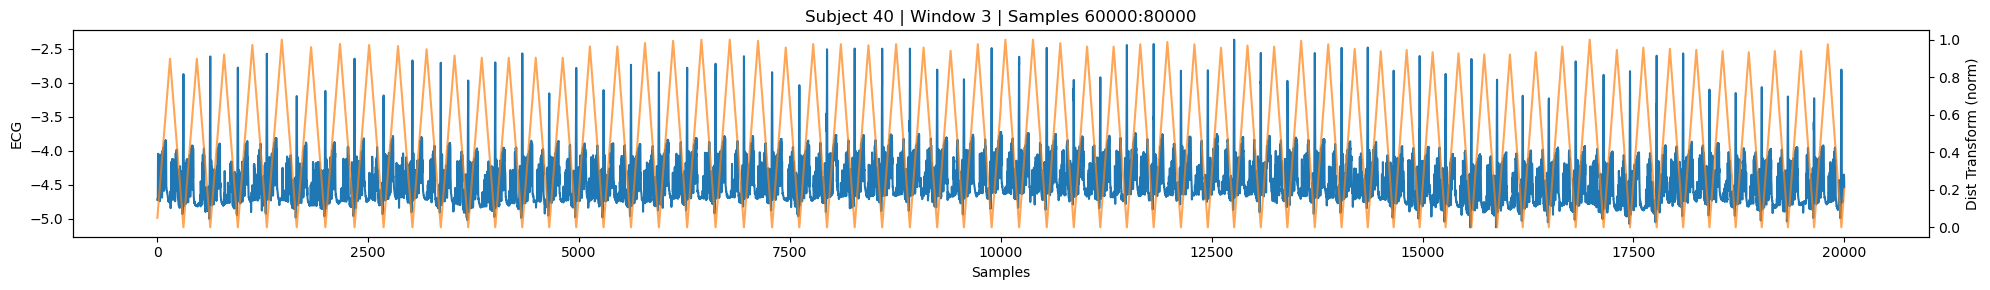

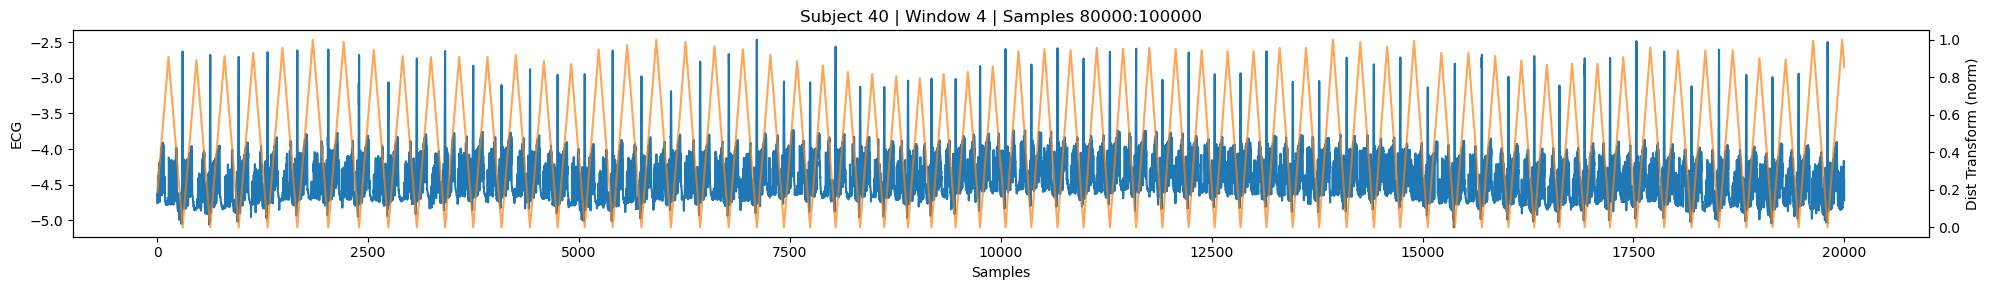

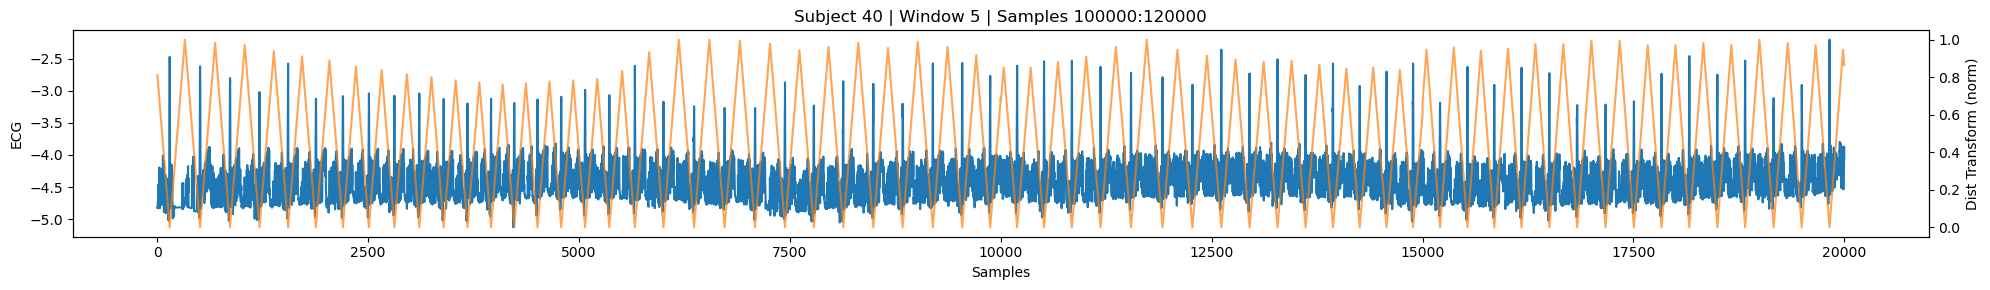

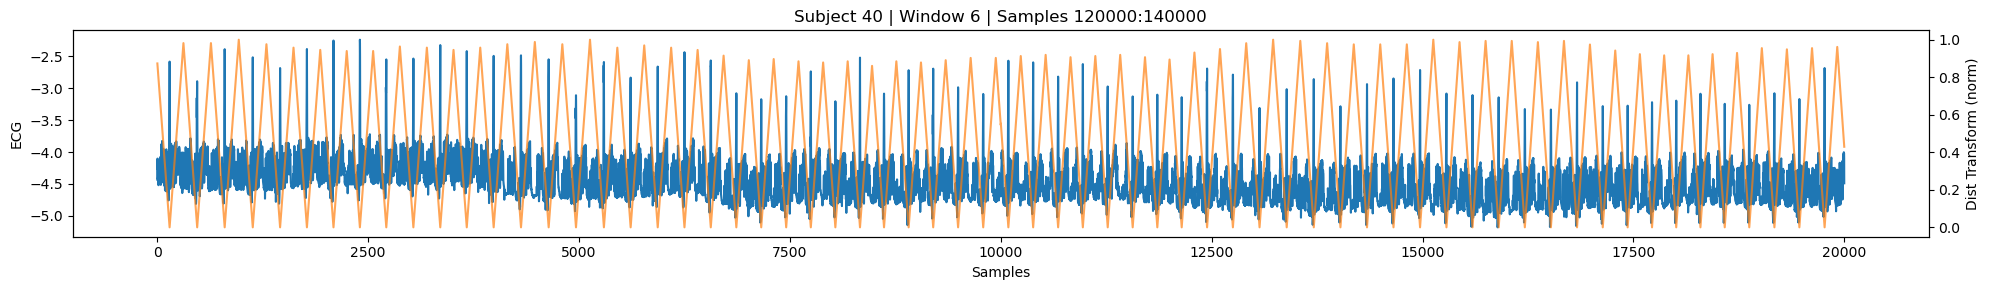

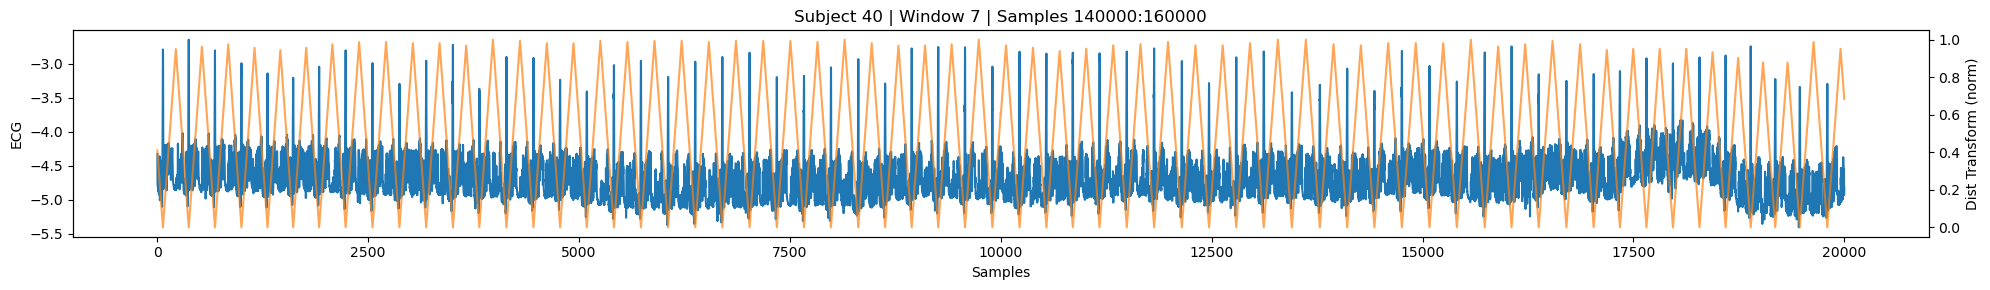

In [25]:
# Multi-subject, multi-window plotting
subjects_to_plot = [40]          # adjust subject indices
window_len = 20000                   # must match earlier usage
max_windows_per_subject = 20         # limit number of windows per subject

for subj in subjects_to_plot:
    if subj >= len(ecg_list):
        print(f'Subject {subj} not available, skipping')
        continue
    ecg_np = np.asarray(ecg_list[subj])
    dt_np = dist_transform[subj, 0, :].numpy()
    T = min(len(ecg_np), len(dt_np))
    n_windows = T // window_len
    if n_windows == 0:
        print(f'Subject {subj} too short for one window, skipping')
        continue
    for w in range(min(n_windows, max_windows_per_subject)):
        start = w * window_len
        end = start + window_len
        ecg_win = ecg_np[start:end]
        dt_win = dt_np[start:end]
        dt_norm = (dt_win - dt_win.min()) / (dt_win.ptp() + 1e-8)

        plt.figure(figsize=(20,3))
        ax1 = plt.gca()
        ax1.plot(ecg_win, color='tab:blue')
        ax2 = ax1.twinx()
        ax2.plot(dt_norm, color='tab:orange', alpha=0.7)
        ax1.set_title(f'Subject {subj} | Window {w} | Samples {start}:{end}')
        ax1.set_xlabel('Samples')
        ax1.set_ylabel('ECG')
        ax2.set_ylabel('Dist Transform (norm)')
        plt.tight_layout()

plt.show()

In [22]:
# Dataset creation with per-window scaling
WINDOW_LEN = 5000

# Convert to numpy if needed
if isinstance(patient_eeg_raw, torch.Tensor):
    patient_eeg_raw = patient_eeg_raw.cpu().numpy()
if isinstance(distance_transform, torch.Tensor):
    distance_transform = distance_transform.cpu().numpy()

n_subjects, n_channels, T = patient_eeg_raw.shape

# Convert ecg_list to numpy array
ecg_array = np.zeros((n_subjects, T), dtype=np.float32)
for i, ecg in enumerate(ecg_list):
    ecg_array[i, :len(ecg)] = ecg

def windows_from_subject(x_sub, window_len):
    cut = (x_sub.shape[1] // window_len) * window_len
    if cut == 0:
        return np.empty((0, x_sub.shape[0], window_len), dtype=x_sub.dtype)
    x_cut = x_sub[:, :cut]
    n_windows = cut // window_len
    resh = x_cut.reshape(x_sub.shape[0], n_windows, window_len)
    return np.transpose(resh, (1, 0, 2))

def scale_window_standard(x_win):
    # x_win: (channels, window_len) -> z-score per channel
    mean = x_win.mean(axis=1, keepdims=True)
    std = x_win.std(axis=1, keepdims=True) + 1e-8
    return (x_win - mean) / std

def scale_window_minmax(y_win):
    # y_win: (1, window_len) -> MinMax per window
    y = y_win.ravel()
    return ((y - y.min()) / (y.ptp() + 1e-8)).reshape(1, -1)

X_train_list, Y_train_list, ECG_train_list = [], [], []
X_val_list, Y_val_list, ECG_val_list = [], [], []
X_test_list, Y_test_list, ECG_test_list = [], [], []

for subj in range(n_subjects):
    x_sub = patient_eeg_raw[subj]       # (n_channels, T)
    y_sub = distance_transform[subj:subj+1]  # (1, T)
    ecg_sub = ecg_array[subj:subj+1]    # (1, T)
    
    x_wins = windows_from_subject(x_sub, WINDOW_LEN)  # (n_w, n_channels, W)
    y_wins = windows_from_subject(y_sub, WINDOW_LEN)  # (n_w, 1, W)
    ecg_wins = windows_from_subject(ecg_sub, WINDOW_LEN)  # (n_w, 1, W)
    
    # Per-window scaling
    for i in range(x_wins.shape[0]):
        x_wins[i] = scale_window_standard(x_wins[i])
        y_wins[i] = scale_window_minmax(y_wins[i])
    
    if subj < 10:  # First 10 subjects -> test
        X_test_list.append(x_wins)
        Y_test_list.append(y_wins)
        ECG_test_list.append(ecg_wins)
    elif subj < 15:  # Next 5 subjects (10-14) -> validation
        X_val_list.append(x_wins)
        Y_val_list.append(y_wins)
        ECG_val_list.append(ecg_wins)
    else:  # Remaining subjects -> train
        X_train_list.append(x_wins)
        Y_train_list.append(y_wins)
        ECG_train_list.append(ecg_wins)

X_train = np.concatenate(X_train_list, axis=0) if X_train_list else np.empty((0, n_channels, WINDOW_LEN))
Y_train = np.concatenate(Y_train_list, axis=0) if Y_train_list else np.empty((0, 1, WINDOW_LEN))
ECG_train = np.concatenate(ECG_train_list, axis=0) if ECG_train_list else np.empty((0, 1, WINDOW_LEN))
X_val = np.concatenate(X_val_list, axis=0) if X_val_list else np.empty((0, n_channels, WINDOW_LEN))
Y_val = np.concatenate(Y_val_list, axis=0) if Y_val_list else np.empty((0, 1, WINDOW_LEN))
ECG_val = np.concatenate(ECG_val_list, axis=0) if ECG_val_list else np.empty((0, 1, WINDOW_LEN))
X_test = np.concatenate(X_test_list, axis=0) if X_test_list else np.empty((0, n_channels, WINDOW_LEN))
Y_test = np.concatenate(Y_test_list, axis=0) if Y_test_list else np.empty((0, 1, WINDOW_LEN))
ECG_test = np.concatenate(ECG_test_list, axis=0) if ECG_test_list else np.empty((0, 1, WINDOW_LEN))

X_train_t = torch.from_numpy(X_train).float()
Y_train_t = torch.from_numpy(Y_train).float()
ECG_train_t = torch.from_numpy(ECG_train).float()
X_val_t = torch.from_numpy(X_val).float()
Y_val_t = torch.from_numpy(Y_val).float()
ECG_val_t = torch.from_numpy(ECG_val).float()
X_test_t = torch.from_numpy(X_test).float()
Y_test_t = torch.from_numpy(Y_test).float()
ECG_test_t = torch.from_numpy(ECG_test).float()

train_ds = TensorDataset(X_train_t, Y_train_t)
val_ds = TensorDataset(X_val_t, Y_val_t)
test_ds = TensorDataset(X_test_t, Y_test_t)
trainloader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
testloader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

torch.save(X_train_t, 'train.pt')
torch.save(X_val_t, 'val.pt')
torch.save(X_test_t, 'test.pt')
torch.save(Y_train_t, 'dist_transform_train.pt')
torch.save(Y_val_t, 'dist_transform_val.pt')
torch.save(Y_test_t, 'dist_transform_test.pt')
torch.save(ECG_train_t, 'ecg_train.pt')
torch.save(ECG_val_t, 'ecg_val.pt')
torch.save(ECG_test_t, 'ecg_test.pt')

print("WINDOW_LEN:", WINDOW_LEN)
print("X_train.shape:", X_train_t.shape, "Y_train.shape:", Y_train_t.shape, "ECG_train.shape:", ECG_train_t.shape)
print("X_val.shape:", X_val_t.shape, "Y_val.shape:", Y_val_t.shape, "ECG_val.shape:", ECG_val_t.shape)
print("X_test.shape:", X_test_t.shape, "Y_test.shape:", Y_test_t.shape, "ECG_test.shape:", ECG_test_t.shape)
print("Per-window scaling: StandardScaler (EEG), MinMaxScaler (DT)")

WINDOW_LEN: 5000
X_train.shape: torch.Size([1190, 128, 5000]) Y_train.shape: torch.Size([1190, 1, 5000]) ECG_train.shape: torch.Size([1190, 1, 5000])
X_val.shape: torch.Size([175, 128, 5000]) Y_val.shape: torch.Size([175, 1, 5000]) ECG_val.shape: torch.Size([175, 1, 5000])
X_test.shape: torch.Size([350, 128, 5000]) Y_test.shape: torch.Size([350, 1, 5000]) ECG_test.shape: torch.Size([350, 1, 5000])
Per-window scaling: StandardScaler (EEG), MinMaxScaler (DT)
